В данном ноутбуке рассчитывается схожесть товаров по текстовому описанию

In [1]:
# !{sys.executable} -m pip install pymystem3
# !{sys.executable} -m pip install nltk

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../src')

In [4]:
import nltk
import numpy as np
import dask.dataframe as dd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from text_preprocessing import text_preprocessing
from cosine_similarity import calculate_text_similarity
from reindexing import reindexing_itemid
import pandas as pd; pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [5]:
# nltk.download('stopwords')

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive')

### Считывание и предобработка данных

In [7]:
details = pd.read_csv('../data/details.csv')

details['attribute_name'] = (
    details['attribute_name']
    .map({'Name': 0, 'Annotation': 1})
    .astype('bool')
)

print(details.shape)
details.head()

(1260590, 3)


,itemid,attribute_name,attribute_value
0,90672,False,Одиночка - Джек
1,90672,True,"Аллан, герой романа `Новичок`, не был преступн..."
2,100658,False,Начала численного анализа
3,100658,True,"Написана по материалом лекций, которые, один ..."
4,120997,False,Физика процессов эволюции


In [8]:
train_target = pd.read_csv('../data/train_with_features.csv')

train_target['clientid'] = train_target['clientid'].astype('uint32')
train_target['jointitemid'] = train_target['jointitemid'].astype('uint32')
train_target['label'] = train_target['label'].astype('int8')
train_target['novelty_cnt'] = train_target['novelty_cnt'].astype('int32')
train_target['count_on_session_view'] = train_target['count_on_session_view'].astype('int32')
train_target['count_on_session_tocart'] = train_target['count_on_session_tocart'].astype('int32')

train_target.shape

(1390438, 25)

In [9]:
test_target = pd.read_csv('../data/test_with_features.csv')

test_target['clientid'] = test_target['clientid'].astype('uint32')
test_target['jointitemid'] = test_target['jointitemid'].astype('uint32')
test_target['label'] = test_target['label'].astype('int8')
test_target['novelty_cnt'] = test_target['novelty_cnt'].astype('int32')
test_target['count_on_session_view'] = test_target['count_on_session_view'].astype('int32')
test_target['count_on_session_tocart'] = test_target['count_on_session_tocart'].astype('int32')

test_target.shape

(597158, 25)

### Препроцессинг текста

In [10]:
details['attribute_value'] = text_preprocessing(details['attribute_value'],
                                                stopwords.words('russian'))

### Разбитие данных по аннотациям и названиям

#### Названия

In [11]:
df_title = (
    details[~details['attribute_name']]
    .fillna('nan')
)

df_title['itemid'], items_mapping_name = reindexing_itemid(df_title)

print(df_title.shape)
df_title.head()

(653916, 3)


,itemid,attribute_name,attribute_value
0,0,False,одиночка джек
2,1,False,начала численного анализа
4,2,False,физика процессов эволюции
6,3,False,уроки госпожи мелодии учебник класса детских м...
8,4,False,эрнест хемингуэй собрание сочинений четырех томах


#### Аннотации

In [12]:
df_annotation = (
    details[details['attribute_name']]
    .fillna('nan')
)

df_annotation['itemid'], items_mapping_annotation = reindexing_itemid(df_annotation)

print(df_annotation.shape)
df_annotation.head()

(606674, 3)


,itemid,attribute_name,attribute_value
1,0,True,аллан герой романа новичок преступником знали ...
3,1,True,написана материалом лекций которые авторов лок...
5,2,True,книга известного немецкого физика эбелинга уче...
7,3,True,издание является учебным пособием новому предм...
9,4,True,третий собрания сочинений включены произведени...


### TF-IDF

In [13]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))

matrix_title = vectorizer.fit_transform(df_title['attribute_value'])
matrix_annotation = vectorizer.fit_transform(df_annotation['attribute_value'])

print(matrix_title.shape, matrix_annotation.shape)

(653916, 59666) (606674, 63966)


### Косинусная схожесть по названиям для train

In [14]:
train_target['item_cat'] = train_target['itemid'].map(items_mapping_name.set_index('old')['new'])
train_target['jointitem_cat'] = train_target['jointitemid'].map(items_mapping_name.set_index('old')['new'])

train_target = calculate_text_similarity(train_target, matrix_title, 'title')

print(train_target.shape)
train_target.head(2)

(1390438, 26)


,clientid,itemid,jointitemid,label,timestamp,view_cnt,to_cart_cnt,ctr,novelty_cnt,view_day_avg_cnt,to_cart_day_avg_cnt,last_day_views_cnt,last_day_to_cart_cnt,relation_ldv_mean,relation_ldtocart_mean,mnk_view,mnk_to_cart,same_items_on_session_view,count_on_session_view,same_items_on_session_tocart,count_on_session_tocart,item_based_view,item_based_tocart,user_based_view,user_based_tocart,same_title
0,7833842,31499843,138176581,1,2019-09-07 20:11:01,31.0,9.0,0.290323,737272,1.722222,1.500,0.0,0.0,0.0,0.0,-0.035714,-0.071429,0.000000,0,0.069338,1,0.0,0.0,0.0,0.0,0.000000
1,19548158,147389610,148381589,0,2019-08-31 22:32:31,24.0,9.0,0.375000,737272,1.600000,1.125,0.0,0.0,0.0,0.0,-0.285714,-0.071429,0.160623,5,0.308607,2,0.0,0.0,0.0,0.0,0.032233


### Косинусная схожесть по аннотациям для train

In [15]:
train_target['item_cat'] = train_target['itemid'].map(items_mapping_annotation.set_index('old')['new'])
train_target['jointitem_cat'] = train_target['jointitemid'].map(items_mapping_annotation.set_index('old')['new'])

train_target = calculate_text_similarity(train_target, matrix_annotation, 'annotation')

train_target = (
    train_target.fillna(0)
)

print(train_target.shape)
train_target.head(2)

(1390438, 27)


,clientid,itemid,jointitemid,label,timestamp,view_cnt,to_cart_cnt,ctr,novelty_cnt,view_day_avg_cnt,to_cart_day_avg_cnt,last_day_views_cnt,last_day_to_cart_cnt,relation_ldv_mean,relation_ldtocart_mean,mnk_view,mnk_to_cart,same_items_on_session_view,count_on_session_view,same_items_on_session_tocart,count_on_session_tocart,item_based_view,item_based_tocart,user_based_view,user_based_tocart,same_title,same_annotation
0,7833842,31499843,138176581,1,2019-09-07 20:11:01,31.0,9.0,0.290323,737272,1.722222,1.500,0.0,0.0,0.0,0.0,-0.035714,-0.071429,0.000000,0,0.069338,1,0.0,0.0,0.0,0.0,0.000000,0.101405
1,19548158,147389610,148381589,0,2019-08-31 22:32:31,24.0,9.0,0.375000,737272,1.600000,1.125,0.0,0.0,0.0,0.0,-0.285714,-0.071429,0.160623,5,0.308607,2,0.0,0.0,0.0,0.0,0.032233,0.000000


### Косинусная схожесть по названиям для test

In [16]:
test_target['item_cat'] = test_target['itemid'].map(items_mapping_name.set_index('old')['new'])
test_target['jointitem_cat'] = test_target['jointitemid'].map(items_mapping_name.set_index('old')['new'])

test_target = calculate_text_similarity(test_target, matrix_title, 'title')

print(test_target.shape)
test_target.head(2)

(597158, 26)


,clientid,itemid,jointitemid,label,timestamp,view_cnt,to_cart_cnt,ctr,novelty_cnt,view_day_avg_cnt,to_cart_day_avg_cnt,last_day_views_cnt,last_day_to_cart_cnt,relation_ldv_mean,relation_ldtocart_mean,mnk_view,mnk_to_cart,same_items_on_session_view,count_on_session_view,same_items_on_session_tocart,count_on_session_tocart,item_based_view,item_based_tocart,user_based_view,user_based_tocart,same_title
0,8081929,152898248,152875664,0,2019-09-06 18:57:23,10.0,2.0,0.200000,737276,2.000000,1.000000,0.0,0.0,0.000000,0.000000,0.214286,0.000000,0.000000,0,0.0,0,0.758175,0.0,0.0,0.0,0.000000
1,33378638,144847078,140715321,0,2019-09-02 07:09:31,211.0,19.0,0.090047,737272,7.814815,1.727273,11.0,1.0,1.407583,0.578947,-6.285714,-0.142857,0.023322,7,0.0,0,0.000000,0.0,0.0,0.0,0.019873


### Косинусная схожесть по аннотациям для test

In [17]:
test_target['item_cat'] = test_target['itemid'].map(items_mapping_annotation.set_index('old')['new'])
test_target['jointitem_cat'] = test_target['jointitemid'].map(items_mapping_annotation.set_index('old')['new'])

test_target= calculate_text_similarity(test_target, matrix_annotation, 'annotation')

test_target = (
    test_target.fillna(0)
)

print(test_target.shape)
test_target.head(2)

(597158, 27)


,clientid,itemid,jointitemid,label,timestamp,view_cnt,to_cart_cnt,ctr,novelty_cnt,view_day_avg_cnt,to_cart_day_avg_cnt,last_day_views_cnt,last_day_to_cart_cnt,relation_ldv_mean,relation_ldtocart_mean,mnk_view,mnk_to_cart,same_items_on_session_view,count_on_session_view,same_items_on_session_tocart,count_on_session_tocart,item_based_view,item_based_tocart,user_based_view,user_based_tocart,same_title,same_annotation
0,8081929,152898248,152875664,0,2019-09-06 18:57:23,10.0,2.0,0.200000,737276,2.000000,1.000000,0.0,0.0,0.000000,0.000000,0.214286,0.000000,0.000000,0,0.0,0,0.758175,0.0,0.0,0.0,0.000000,0.420892
1,33378638,144847078,140715321,0,2019-09-02 07:09:31,211.0,19.0,0.090047,737272,7.814815,1.727273,11.0,1.0,1.407583,0.578947,-6.285714,-0.142857,0.023322,7,0.0,0,0.000000,0.0,0.0,0.0,0.019873,0.284858


In [18]:
def fastText_features(data: pd.DataFrame,
                      model_path: str,
                      attribute_name: str) -> pd.DataFrame:
    """
    Функция для подсчета fastText фичей.
    """
    
    try:
        model = KeyedVectors.load(model_path)
    except IOError:
        raise ValueError('Invalid model')
        
    pairs = data.copy()
    
#     pairs['ft_n_similarity_'+attribute_name] = (
#         [model.n_similarity(x.split(), y.split()) for x, y in zip(pairs['attribute_value_x'], 
#                                                                   pairs['attribute_value_y'])]
#     )
    
    pairs['ft_similarity_'+attribute_name] = (
        [model.similarity(x, y) for x, y in zip(pairs['attribute_value_x'], 
                                                pairs['attribute_value_y'])]
    )
     
    return pairs

In [19]:
df_title['attribute_value'].replace('', 'nan', inplace=True)
df_annotation['attribute_value'].replace('', 'nan', inplace=True)

### fastText схожесть по названиям для train

#### Объединяем данные, чтобы получить 2 признака с названиями в соответствии с (itemid, jointitemid)

In [20]:
train_target['key'] = train_target.index.tolist()
train_target['item_cat'] = train_target['itemid'].map(items_mapping_name.set_index('old')['new'])
train_target['jointitem_cat'] = train_target['jointitemid'].map(items_mapping_name.set_index('old')['new'])

train_target = (
    train_target   
    .merge(df_title[['itemid', 'attribute_value']]
               .rename(columns={'itemid': 'item_cat'}),
           on=['item_cat'], how='left')
    .merge(df_title[['itemid', 'attribute_value']]
               .rename(columns={'itemid': 'jointitem_cat'}),
           on=['jointitem_cat'], how='left')
    .drop_duplicates('key')
    .reset_index(drop=True)
    .drop(['key', 'item_cat', 'jointitem_cat'], axis=1)
)

#### Заменяем nan на строковое значение nan

In [21]:
train_target[['attribute_value_x', 'attribute_value_y']] = (
    train_target[['attribute_value_x', 'attribute_value_y']].fillna('nan', axis=1)
)

In [22]:
train_target = (
    fastText_features(train_target,
                      '../models/fasttext/213/model.model',
                      'title')
)

#### Заменяем значения на 0 в парах, где встречается nan

In [23]:
train_target.loc[train_target['attribute_value_x'] == 'nan', 'ft_similarity_title'] = 0.0
train_target.loc[train_target['attribute_value_y'] == 'nan', 'ft_similarity_title'] = 0.0

In [24]:
print(train_target.shape)
train_target = train_target.drop(['attribute_value_x', 'attribute_value_y'], axis=1)
print(train_target.shape)

(1390438, 30)
(1390438, 28)


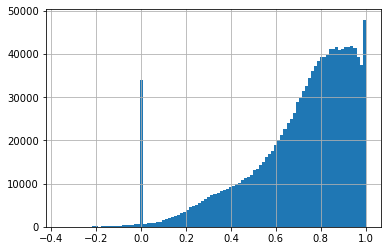

In [25]:
train_target['ft_similarity_title'].hist(bins=100);

### fastText схожесть по названиям для test

#### Объединяем данные, чтобы получить 2 признака с названиями в соответствии с (itemid, jointitemid)

In [26]:
test_target['key'] = test_target.index.tolist()
test_target['item_cat'] = test_target['itemid'].map(items_mapping_name.set_index('old')['new'])
test_target['jointitem_cat'] = test_target['jointitemid'].map(items_mapping_name.set_index('old')['new'])

test_target = (
    test_target   
    .merge(df_title[['itemid', 'attribute_value']]
               .rename(columns={'itemid': 'item_cat'}),
           on=['item_cat'], how='left')
    .merge(df_title[['itemid', 'attribute_value']]
               .rename(columns={'itemid': 'jointitem_cat'}),
           on=['jointitem_cat'], how='left')
    .drop_duplicates('key')
    .reset_index(drop=True)
    .drop(['key', 'item_cat', 'jointitem_cat'], axis=1)
)

#### Заменяем nan на строковое значение nan

In [27]:
test_target[['attribute_value_x', 'attribute_value_y']] = (
    test_target[['attribute_value_x', 'attribute_value_y']].fillna('nan', axis=1)
)

In [28]:
test_target = (
    fastText_features(test_target,
                      '../models/fasttext/213/model.model',
                      'title')
)

#### Заменяем значения на 0 в парах, где встречается nan

In [29]:
test_target.loc[test_target['attribute_value_x'] == 'nan', 'ft_similarity_title'] = 0.0
test_target.loc[test_target['attribute_value_y'] == 'nan', 'ft_similarity_title'] = 0.0

In [30]:
print(test_target.shape)
test_target = test_target.drop(['attribute_value_x', 'attribute_value_y'], axis=1)
print(test_target.shape)

(597158, 30)
(597158, 28)


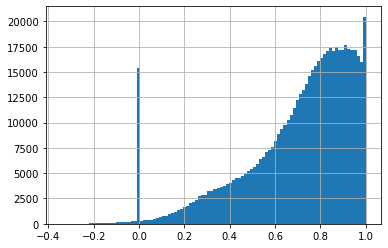

In [31]:
test_target['ft_similarity_title'].hist(bins=100);

### Сохраняем принаки

In [32]:
train_target.to_csv('../data/train_with_features.csv', index=False)
test_target.to_csv('../data/test_with_features.csv', index=False)